In [1]:
import glob
import os

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import sunpy.coordinates.sun as sn

import huxt as H
import huxt_analysis as HA
import sir_huxt_mono_obs as sir
import sir_huxt_plots as sirplt


mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)

In [3]:
def summarise_osse_data(files):
    """
    Function to load and summarise the results from an SIR osse experiment. Takes a list of files returned by the osse, 
    and returns a dictionary summarising the ensemble and ensemble average of CME properties
    
    """
    # Get list of parameters to aggregate compute
    keys = ['v', 'v_avg', 'v_std', 'v_rank',
            'width', 'width_avg', 'width_std', 'width_rank',
            'lon', 'lon_avg', 'lon_std', 'lon_rank',
            't_transit', 't_transit_avg', 't_transit_std',
            'v_hit', 'v_hit_avg', 'v_hit_std', 'e_obs']
    
    # Make dictionary to store aggregated ensemble data and computed statistics
    data = {'prior':{k:[] for k in keys}, 'post':{k:[] for k in keys},
            'truth':{'v':[], 'width':[], 'lon':[], 't_transit':[], 'v_hit':[]}}

    # Set a counter for files with no data for the prior or posterior steps
    bad_count = 0

    for i, f in enumerate(files):

        out_file = h5py.File(f, 'r')    

        # First file only, pull out the truth data. This is
        # identical across files
        if i == 0:
            # Parse out the true CME values
            cme_truth_params = out_file['truth_cme_params'][:]        
            data['truth']['v'] = cme_truth_params[4]
            data['truth']['width'] = np.rad2deg(cme_truth_params[3])
            lon_truth = np.rad2deg(cme_truth_params[1])
            if lon_truth > 180:
                lon_truth -= 360
            data['truth']['lon'] = lon_truth
            data['truth']['t_transit'] = out_file['t_transit_truth'][()] # PARALEL REQUIRES _TRUTH
            data['truth']['v_hit'] = out_file['v_hit_truth'][()]

        # Now pull out the ensemble data for the prior and posterior
        for j, key in enumerate(['prior', 'post']):
            
            if key == 'prior':
                analysis_key = 'analysis_00'
            elif key == 'post':
                analysis_key = 'analysis_07'

            if analysis_key not in out_file.keys():
                bad_count += 1
                continue
            
            data[key]['e_obs'].append(out_file[analysis_key]['e_obs'][()])
                                      
            for param in ['v', 'width', 'lon', 't_transit', 'v_hit']:
                # Now pass out the ensemble data
                x = out_file[analysis_key][param][:]
                if param == 'lon':
                    x[x>180] -= 360
                    data[key]['n_ens'] = len(x)
                    
                data[key][param].append(x)
                data[key][param + '_avg'].append(np.mean(x))
                data[key][param + '_std'].append(np.std(x))
                
                # Now compute rank of truth in each ensemble of CME core parameters
                if param in ['v', 'width', 'lon']:
                    x_truth = data['truth'][param]
                    x_all = np.append(x, x_truth)
                    x_ranks = st.rankdata(x_all)
                    data[key][param + '_rank'].append(x_ranks[-1])

        out_file.close()

    # Turn the lists to numpy arrays
    for key in ['prior', 'post']:
        for param, vals in data[key].items():
            data[key][param] = np.array(vals).ravel()
    
    return data


def plot_particle_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(2, 3, figsize=(19, 12))

    vmin = data['prior']['v'].min() - 25
    vmax = data['prior']['v'].max() + 25
    wmin = data['prior']['width'].min() - 5
    wmax = data['prior']['width'].max() + 5
    lmin = data['prior']['lon'].min() - 5
    lmax = data['prior']['lon'].max() + 5
    
    vwlims = (vmin, vmax, wmin, wmax)
    vllims = (vmin, vmax, lmin, lmax)
    wllims = (wmin, wmax, lmin, lmax)
    
    zmin = 0
    zmax = 150
    # define the bins and normalize
    cmap = mpl.cm.get_cmap('viridis')
    bounds = np.arange(zmin, zmax + 10, 10)
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    for i, key in enumerate(['prior', 'post']):
        ax[i, 0].hexbin(data[key]['v'], data[key]['width'], gridsize=15, extent=vwlims, norm=norm, cmap=cmap)
        ax[i, 1].hexbin(data[key]['v'], data[key]['lon'], gridsize=15, extent=vllims, norm=norm, cmap=cmap)
        hb = ax[i, 2].hexbin(data[key]['width'], data[key]['lon'], gridsize=15, extent=wllims, norm=norm, cmap=cmap)

    
    # Format the axes
    for a in ax[:,0]:
        a.vlines(data['truth']['v'], vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['width'], vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vwlims[0], vwlims[1])
        a.set_ylim(vwlims[2], vwlims[3]) 
        a.set_xlabel('Speed (km/s)')
        a.set_ylabel('Width (deg)')

    for a in ax[:, 1]:
        a.vlines(data['truth']['v'], vllims[2], vllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], vllims[0], vllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vllims[0], vllims[1])
        a.set_ylim(vllims[2], vllims[3])
        a.set_xlabel('Speed (km/s)')
        a.set_ylabel('Longitude (deg)')
        a.yaxis.labelpad = -15

    for a in ax[:, 2]:
        a.vlines(data['truth']['width'], wllims[2], wllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], wllims[0], wllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(wllims[0], wllims[1])
        a.set_ylim(wllims[2], wllims[3])
        a.set_xlabel('Width (deg)')
        a.set_ylabel('Longitude (deg)')
        a.yaxis.labelpad = -15

    labels = ['Prior', 'Posterior']
    for i, lab in enumerate(labels):
        for j in range(ax.shape[1]):
            ax[i, j].text(0.98, 0.925, lab, fontsize=20, color='w', ha='right', transform=ax[i, j].transAxes)
    
    labels = ["A)", "B)", "C)", "D)", "E)", "F)"]
    for a, lab in zip(ax.ravel(), labels):
        a.text(0.015, 0.925, lab, fontsize=20, color='w', transform=a.transAxes)

    fig.subplots_adjust(left=0.06, bottom=0.06, right=0.93, top=0.99, wspace=0.2, hspace=0.125)

    pos1 = ax[0, 2].get_position()
    pos2 = ax[1, 2].get_position()
    dw = 0.005
    dh = 0.1
    top = pos1.y1
    bottom = pos2.y0
    height = top - bottom
    left = pos1.x1 + pos1.width/20
    wid = pos1.width/20
    cbaxes = fig.add_axes([left, bottom, wid, height])
    cbar = fig.colorbar(hb, cax=cbaxes, orientation='vertical')
    cbar.set_label('Count')
    
    return fig, ax

def plot_average_particle_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(2, 3, figsize=(19, 12))

    vmin = data['prior']['v_avg'].min() - 25
    vmax = data['prior']['v_avg'].max() + 25
    wmin = data['prior']['width_avg'].min() - 5
    wmax = data['prior']['width_avg'].max() + 5
    lmin = data['prior']['lon_avg'].min() - 5
    lmax = data['prior']['lon_avg'].max() + 5
    
    vwlims = (vmin, vmax, wmin, wmax)
    vllims = (vmin, vmax, lmin, lmax)
    wllims = (wmin, wmax, lmin, lmax)
    
    zmin = 0
    zmax = 10
    # define the bins and normalize
    cmap = mpl.cm.get_cmap('viridis')
    bounds = np.arange(zmin, zmax + 1, 1)
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    for i, key in enumerate(['prior', 'post']):
        ax[i, 0].hexbin(data[key]['v_avg'], data[key]['width_avg'], gridsize=10, extent=vwlims, norm=norm, cmap=cmap)
        ax[i, 1].hexbin(data[key]['v_avg'], data[key]['lon_avg'], gridsize=10, extent=vllims, norm=norm, cmap=cmap)
        hb = ax[i, 2].hexbin(data[key]['width_avg'], data[key]['lon_avg'], gridsize=10, extent=wllims, norm=norm, cmap=cmap)

    # Format the axes
    for a in ax[:, 0]:
        a.vlines(data['truth']['v'], vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['width'], vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vwlims[0], vwlims[1])
        a.set_ylim(vwlims[2], vwlims[3]) 
        a.set_xlabel('$\\langle Speed \\rangle_{{ens}}$ (km/s)')
        a.set_ylabel('$\\langle Width \\rangle_{{ens}} (deg)$')

    for a in ax[:, 1]:
        a.vlines(data['truth']['v'], vllims[2], vllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], vllims[0], vllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vllims[0], vllims[1])
        a.set_ylim(vllims[2], vllims[3])
        a.set_xlabel('$\\langle Speed \\rangle_{{ens}}$ (km/s)')
        a.set_ylabel('$\\langle Lon \\rangle_{{ens}}$ (deg)')
        a.yaxis.labelpad = -15

    for a in ax[:, 2]:
        a.vlines(data['truth']['width'],wllims[2], wllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], wllims[0], wllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(wllims[0], wllims[1])
        a.set_ylim(wllims[2], wllims[3])
        a.set_xlabel('$\\langle Width \\rangle_{{ens}}$ (deg)')
        a.set_ylabel('$\\langle Lon \\rangle_{{ens}}$ (deg)')
        a.yaxis.labelpad = -15

    labels = ['Prior', 'Posterior']
    for i, lab in enumerate(labels):
        for j in range(ax.shape[1]):
            ax[i, j].text(0.98, 0.925, lab, fontsize=20, color='w', ha='right', transform=ax[i, j].transAxes)
    
    labels = ["A)", "B)", "C)", "D)", "E)", "F)"]
    for a, lab in zip(ax.ravel(), labels):
        a.text(0.015, 0.925, lab, fontsize=20, color='w', transform=a.transAxes)

    fig.subplots_adjust(left=0.05, bottom=0.06, right=0.94, top=0.99, wspace=0.2, hspace=0.125)

    pos1 = ax[0, 2].get_position()
    pos2 = ax[1, 2].get_position()
    dw = 0.005
    dh = 0.1
    top = pos1.y1
    bottom = pos2.y0
    height = top - bottom
    left = pos1.x1 + pos1.width/20
    wid = pos1.width/20
    cbaxes = fig.add_axes([left, bottom, wid, height])
    cbar = fig.colorbar(hb, cax=cbaxes, orientation='vertical')
    cbar.set_label('Count')
    
    return fig, ax


def plot_arrival_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Density estimates of arrival time
    t_arr_hists = [data[key]['t_transit']/3600 for key in ['prior', 'post']]
    v_hit_hists = [data[key]['v_hit'] for key in ['prior', 'post']]
    
    t_min = t_arr_hists[0].min() - 1
    t_max = t_arr_hists[0].max() + 1
    
    v_min = v_hit_hists[0].min() - 5
    v_max = v_hit_hists[0].max() + 5
    
    lims = (t_min, t_max, v_min, v_max)
    
    labels = ['No DA', 'With DA']
    nt, bins, patch = ax[0].hist(t_arr_hists, np.arange(lims[0], lims[1], 0.5), density=True, label=labels)
    nt_max = np.max([np.max(n) for n in nt])
    nt_max = 1.1*nt_max
    ax[0].vlines(data['truth']['t_transit']/3600, 0, nt_max, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')
    
    nv, bins, patch = ax[1].hist(v_hit_hists, np.arange(lims[2], lims[3], 5), density=True, label=labels)
    nv_max = np.max([np.max(n) for n in nv])
    nv_max = 1.1*nv_max
    ax[1].vlines(data['truth']['v_hit'], 0, nv_max, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')
    

    ax[2].plot(t_arr_hists[0], v_hit_hists[0],'s', color="C0", label=labels[0])
    ax[2].plot(t_arr_hists[1], v_hit_hists[1],'o', color="C1", label=labels[1])
    ax[2].hlines(data['truth']['v_hit'], lims[0], lims[1], zorder=9, linestyle=['--'], colors='r', linewidth=3)
    ax[2].vlines(data['truth']['t_transit']/3600, lims[2], lims[3], zorder=9, linestyle=['--'], colors='r', linewidth=3)
    
    ax[0].set_xlabel('Transit time (hours)')
    ax[0].set_ylabel('Density')
    
    ax[1].set_xlabel('Arrival speed (km/s)')
    ax[1].set_ylabel('Density')
    
    ax[2].set_xlabel('Transit time (hours)')
    ax[2].set_ylabel('Arrival speed (km/s)')
    
    ax[0].set_xlim(lims[0], lims[1])
    ax[0].set_ylim(0, nt_max)
    
    ax[1].set_xlim(lims[2], lims[3])
    ax[1].set_ylim(0, nv_max)
    
    ax[2].set_xlim(lims[0], lims[1])
    ax[2].set_ylim(lims[2], lims[3])
    
    for a, lab in zip(ax, ['A)', 'B)', 'C)']):
        a.legend()
        a.text(0.01, 0.925, lab, fontsize=14, transform=a.transAxes)
        
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.975, wspace=0.18)
    
    return fig, ax


def plot_average_arrival_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Density estimates of arrival time
    t_arr_hists = [data[key]['t_transit_avg']/3600 for key in ['prior', 'post']]
    v_hit_hists = [data[key]['v_hit_avg'] for key in ['prior', 'post']]
    
    t_min = t_arr_hists[0].min() - 1
    t_max = t_arr_hists[0].max() + 1
    
    v_min = v_hit_hists[0].min() - 5
    v_max = v_hit_hists[0].max() + 5
    
    lims = (t_min, t_max, v_min, v_max)
    
    labels = ['Prior', 'Posterior']
    nt, bins, patch = ax[0].hist(t_arr_hists, np.arange(lims[0], lims[1], 0.5), density=True, label=labels)
    nt_max = np.max([np.max(n) for n in nt])
    nt_max = 1.1*nt_max
    ax[0].vlines(data['truth']['t_transit']/3600, 0, nt_max, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')
    
    nv, bins, patch = ax[1].hist(v_hit_hists, np.arange(lims[2], lims[3], 5), density=True, label=labels)
    nv_max = np.max([np.max(n) for n in nv])
    nv_max = 1.1*nv_max
    ax[1].vlines(data['truth']['v_hit'], 0, nv_max, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')
    

    ax[2].plot(t_arr_hists[0], v_hit_hists[0],'s', color="C0", label=labels[0])
    ax[2].plot(t_arr_hists[1], v_hit_hists[1],'o', color="C1", label=labels[1])
    ax[2].hlines(data['truth']['v_hit'], lims[0], lims[1], zorder=9, linestyle=['--'], colors='r', linewidth=3)
    ax[2].vlines(data['truth']['t_transit']/3600, lims[2], lims[3], zorder=9, linestyle=['--'], colors='r', linewidth=3)
    
    ax[0].set_xlabel('Mean Transit time (hours)')
    ax[0].set_ylabel('Density')
    
    ax[1].set_xlabel('Mean Arrival speed (km/s)')
    ax[1].set_ylabel('Density')
    
    ax[2].set_xlabel('Mean Transit time (hours)')
    ax[2].set_ylabel('Mean Arrival speed (km/s)')
    
    ax[0].set_xlim(lims[0], lims[1])
    ax[0].set_ylim(0, nt_max)
    
    ax[1].set_xlim(lims[2], lims[3])
    ax[1].set_ylim(0, nv_max)
    
    ax[2].set_xlim(lims[0], lims[1])
    ax[2].set_ylim(lims[2], lims[3])
    
    for a, lab in zip(ax, ['A)', 'B)', 'C)']):
        a.legend()
        a.text(0.01, 0.925, lab, fontsize=14, transform=a.transAxes)
        
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.975, wspace=0.18)
    
    return fig, ax


def plot_rank_histogram(data):
    n_ens = data['post']['n_ens']
    bins = np.arange(-3, n_ens + 3, 3)
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    for i, (param, label) in enumerate(zip(['v', 'width', 'lon'], ['Speed', 'Width', 'Longitude'])):

        ranks = [data['prior'][param + '_rank'], data['post'][param + '_rank']]

        ax[i].hist(ranks, bins=bins, label=[label+ ' Prior', label + ' Posterior'])

        ax[i].set_xlim(0,51)
        ax[i].set_ylim(0,20)
        ax[i].set_xlabel('Rank')
        ax[i].set_ylabel('Frequency')

        ax[i].legend()
        
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.975, wspace=0.18)
    
    return fig, ax

    
def cme_scenarios_huxt_plot():
    """
    Generate a plot that shows the different CME scenarios and observer locations
    """
    fig, ax = plt.subplots(1, 4, figsize=(35, 10), subplot_kw={"projection": "polar"})
    fig.subplots_adjust(left=0.01, bottom=0.12, right=0.99, top=0.99, wspace=0.025)

    model, model1d = sir.setup_huxt(dt_scale=20)

    for a, letter, scenario in zip(ax, ['A', 'B', 'C', 'D'], ['slow_narrow', 'slow_wide', 'fast_narrow', 'fast_wide']):
        cme = sir.get_cme_scenario(model, scenario)

        model.solve([cme])
        time = 1.0*u.day
        obs_list = [sir.Observer(model, model.cmes[0], l*u.deg, el_min=4.0, el_max=35.0) for l in np.arange(-90,-10,10)]    
        if (letter == 'A') | (letter == 'D'):
            obs = []    
            addflank = False
            addfov = False
        elif letter == 'B':
            obs = obs_list
            addflank = False
            addfov = False
        elif letter == 'C':
            obs = [obs_list[3]]
            addflank = True
            addfov = True

        sirplt.plot_huxt_with_observer(model, time, obs, fighandle=fig, axhandle=a, add_fov=addfov, add_flank=addflank)

        label = scenario.split("_")
        label = "({}) {}-{}".format(letter, label[0].capitalize(), label[1].capitalize())
        a.text(0.5, 0.9, label, color='k', ha='center', fontsize=25, transform=a.transAxes)

    dirs = sir.get_project_dirs()
    name = 'huxt_cme_scenarios.png'
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    return


def helcats_cme_scenarios_plot():
    """
    Generate plot of the HELCATS CME speed vs width, and mark on the 4 CME scenarios used here
    """

    project_dirs = sir.get_project_dirs()
    column_names = ['ID', 'pre_date', 'pre_time', 'last_date', 'last_time', 'carlon',
                    'stolon', 'stolat', 'tilt', 'ssprat', 'h_angle', 'speed',  'mass']
    data = pd.read_csv(project_dirs['HELCATS_data'], names=column_names, skiprows=4, delim_whitespace=True)

    # Load the CME scenarios
    scenarios = sir.load_cme_scenarios()

    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(data['speed'], 2*data['h_angle'], 'ko')

    for key, param in scenarios.items():
        ax.plot(param['speed'].value, param['width'].value, 'h', color='darkorange', markersize=20)

    # Add on marks for the percentiles
    v_min = scenarios['slow_narrow']['speed'].value
    w_min = scenarios['slow_narrow']['width'].value
    v_max = scenarios['fast_wide']['speed'].value
    w_max = scenarios['fast_wide']['width'].value

    ax.vlines(v_min, 0, 150, linestyles='--', colors='darkred')
    ax.vlines(v_max, 0, 150, linestyles=':', colors='olive')
    ax.hlines(w_min, 0, 3000, linestyles='--', colors='teal')
    ax.hlines(w_max, 0, 3000, linestyles=':', colors='mediumorchid')

    label = "{:3.0f} km/s".format(v_min)
    ax.text(v_min + 20, 120, label, color='darkred', fontsize=14)
    label = "{:3.0f} km/s".format(v_max)
    ax.text(v_max + 20, 120, label, color='olive', fontsize=14)
    label = "{} deg".format(w_min)
    ax.text(2200, w_min - 5, label, color='teal', fontsize=14)
    label = "{} deg".format(w_max)
    ax.text(2200, w_max - 5, label, color='mediumorchid', fontsize=14)

    ax.set_xlabel('CME Speed (km/s)')
    ax.set_ylabel('CME Width (degrees)')
    ax.set_xlim(100, 2800)
    ax.set_ylim(10, 130)

    fig.subplots_adjust(left=0.12, bottom=0.085, right=0.99, top=0.99)
    dirs = sir.get_project_dirs()
    name = 'helcats_stats.png'
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    plt.close('all')
    return


def resampling_example_plot():
    """
    Make plot to show how the resampling procedure works
    """

    dirs = sir.get_project_dirs()
    dir_tag = 'obs_lon_300_cme_average'
    data_path = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_run_000.hdf5")

    out_file = h5py.File(data_path, 'r')    

    # Now pass out the ensemble data
    v0 = out_file['analysis_00']['v'][:]
    v1 = out_file['analysis_01']['v'][:]

    w0 = out_file['analysis_00']['width'][:]
    w1 = out_file['analysis_01']['width'][:]

    l0 = out_file['analysis_00']['lon'][:]
    l1 = out_file['analysis_01']['lon'][:]

    l0[l0>180]+=-360
    l1[l1>180]+=-360

    weights = out_file['analysis_00']['weight'][:]
    sz = 10 + 100*(weights - weights.min()) /np.ptp(weights) 

    fig, ax = plt.subplots(2, 3, figsize=(19, 12))

    zmin = 0
    zmax = 0.5
    # define the bins and normalize
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=zmin, vmax=zmax)

    for a, data in zip(ax[0,:], ((v0, w0), (v0, l0), (w0, l0))):

        x = data[0]
        y = data[1]
        x_z, x_avg, x_std = sir.zscore(x)
        y_z, y_avg, y_std = sir.zscore(y)

        data_sub = np.array([x_z, y_z]).T

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data_sub)
        xd = np.arange(-2, 2, 0.01)
        yd = np.arange(-2, 2, 0.01)
        xd, yd = np.meshgrid(xd, yd)
        xo = xd*x_std + x_avg
        yo = yd*y_std + y_avg
        coords = np.array([xd.ravel(), yd.ravel()]).T
        pdf = np.exp(kde.score_samples(coords))
        pdf = pdf.reshape(xd.shape)

        a.contourf(xo, yo, pdf, norm=norm, cmap=cmap)
        a.plot(x, y, 'ro')

    for a, data in zip(ax[1,:], ((v0, w0), (v0, l0), (w0, l0))):

        x = data[0]
        y = data[1]
        x_z, x_avg, x_std = sir.zscore(x)
        y_z, y_avg, y_std = sir.zscore(y)

        data_sub = np.array([x_z, y_z]).T

        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data_sub, sample_weight=weights.ravel())
        xd = np.arange(-2, 2, 0.01)
        yd = np.arange(-2, 2, 0.01)
        xd, yd = np.meshgrid(xd, yd)
        xo = xd*x_std + x_avg
        yo = yd*y_std + y_avg
        coords = np.array([xd.ravel(), yd.ravel()]).T
        pdf = np.exp(kde.score_samples(coords))
        pdf = pdf.reshape(xd.shape)

        cnt = a.contourf(xo, yo, pdf, norm=norm, cmap=cmap)
        a.scatter(x, y, s=sz, color='r', marker='o')

    ax[1,0].plot(v1, w1, 'ks')
    ax[1,1].plot(v1, l1, 'ks')
    ax[1,2].plot(w1, l1, 'ks')

    # Format the axes
    for a in ax[:,0]:
        a.set_xlabel('V')
        a.set_ylabel('Width')

    for a in ax[:, 1]:
        a.set_xlabel('V')
        a.set_ylabel('Lon')

    for a in ax[:, 2]:
        a.set_xlabel('Width')
        a.set_ylabel('Lon')

    labels = ['Prior', 'Weighted + Resampled']
    for i, lab in enumerate(labels):
        for j in range(ax.shape[1]):
            ax[i, j].text(0.015, 0.95, lab, fontsize=20, color='w', transform=ax[i, j].transAxes)

    fig.subplots_adjust(left=0.06, bottom=0.06, right=0.93, top=0.99, wspace=0.15, hspace=0.125)

    pos1 = ax[0, 2].get_position()
    pos2 = ax[1, 2].get_position()
    dw = 0.005
    dh = 0.1
    top = pos1.y1
    bottom = pos2.y0
    height = top - bottom
    left = pos1.x1 + pos1.width/20
    wid = pos1.width/20
    cbaxes = fig.add_axes([left, bottom, wid, height])
    cbar = fig.colorbar(cnt, cax=cbaxes, orientation='vertical')
    cbar.set_label('Density')

    out_file.close()

    dirs = sir.get_project_dirs()
    name = 'resampling_example.png'
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    plt.close('all')
    return


Lon = -3.94 deg
Width = 36.98 deg
Speed = 477.97 km/s
**********************
Transit time uncertainty
[5.32888847 4.39817549 3.74203065 2.58905077 1.48629438 0.97044153
 0.80514816 0.9318594 ]
**********************


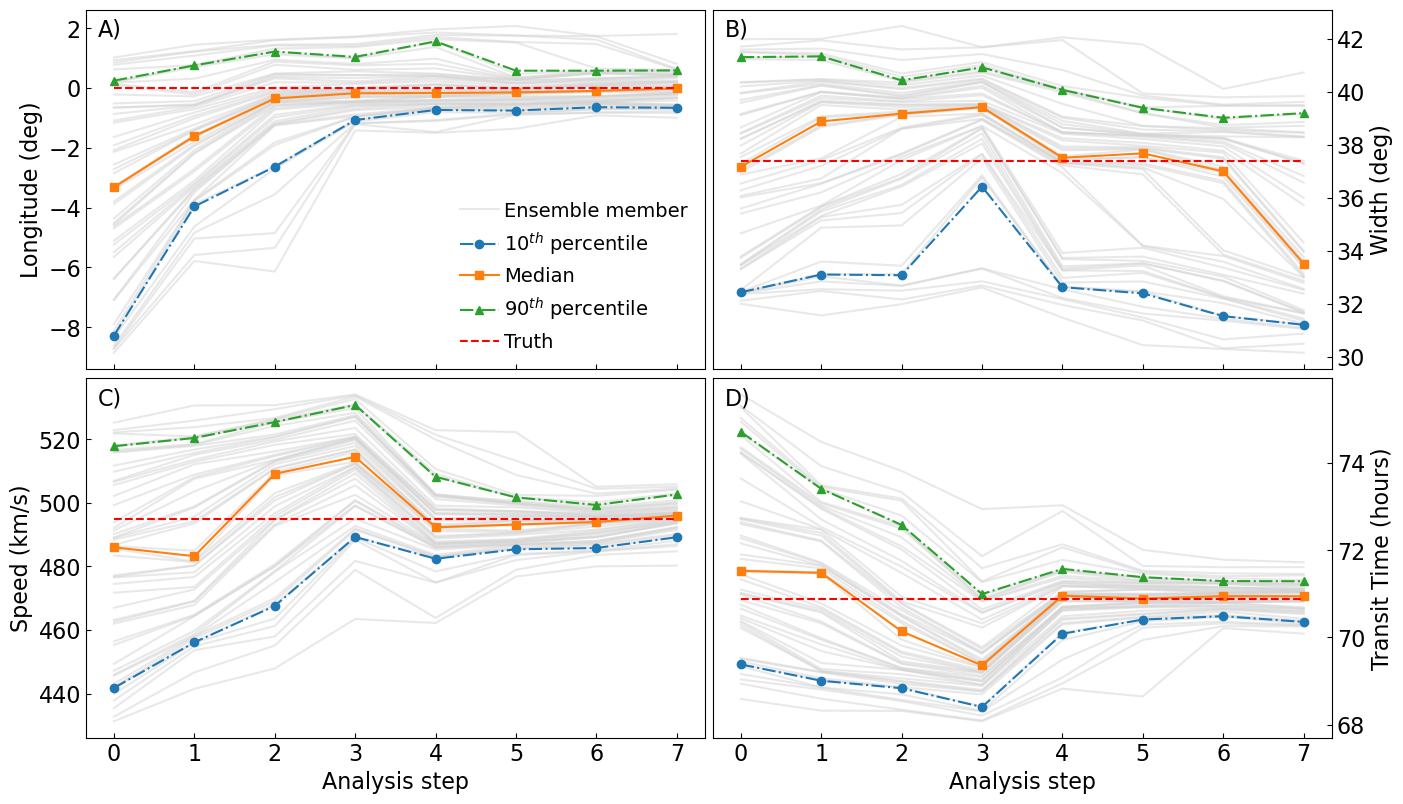

In [3]:
#280 fast_narrow_np, file 6

#300 slow narrow file 7 is good

#300 slow wide 7 is good

lon = 300
scenario = 'slow_narrow_mp'

analysis_keys = ["analysis_{:02d}".format(i) for i in range(8)]

fig, ax = plt.subplots(2, 2, figsize=(14,8))

dirs = sir.get_project_dirs()
dir_tag = 'obs_lon_{}_cme_{}'.format(lon, scenario)
data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
files = glob.glob(data_dir)

steps = np.arange(0, len(analysis_keys), 1)

file_in = files[7]
out_file = h5py.File(files[7], 'r')    

# First file only, pull out the truth data. This is
# identical across files
# Parse out the true CME values
cme_truth_params = out_file['truth_cme_params'][:]
l_tr = np.rad2deg(cme_truth_params[1])
w_tr = np.rad2deg(cme_truth_params[3])
v_tr = cme_truth_params[4]
tt_tr = out_file['t_transit_truth'][()] / 3600

l_all = np.zeros((50, steps.size))
w_all = np.zeros((50, steps.size))
v_all = np.zeros((50, steps.size))
tt_all = np.zeros((50, steps.size))

for j, analysis_key in enumerate(analysis_keys):
    # Now pass out the ensemble data
    l = out_file[analysis_key]['lon'][:]
    l[l>180]-=360
    l_all[:, j] = np.sort(l)

    w = out_file[analysis_key]['width'][:]    
    w_all[:, j] = np.sort(w)
    
    v = out_file[analysis_key]['v'][:]
    v_all[:, j] = np.sort(v)
    
    tt = out_file[analysis_key]['t_transit'][:]
    tt_all[:, j] = np.sort(tt/3600)

cme_init = out_file['cme_inital_values'][:]
width_init = np.rad2deg(cme_init[3])
v_init = cme_init[4]
lon_init = np.rad2deg(cme_init[1])
if lon_init > 180:
    lon_init -= 360

print("Lon = {:3.2f} deg".format(lon_init))
print("Width = {:3.2f} deg".format(width_init))
print("Speed = {:3.2f} km/s".format(v_init))
out_file.close()

for a, data in zip(ax.ravel(), [l_all, w_all, v_all, tt_all]):
    a.plot(steps, data.T, '-', color='lightgrey', alpha=0.5, zorder=0)
    a.plot([],[],'-', color='lightgrey', alpha=0.5, zorder=0, label='Ensemble member')
    res = np.percentile(data, [10, 50, 90], axis=0)
    a.plot(steps, res[0,:], 'o-.', zorder=1, label='$10^{th}$ percentile')
    a.plot(steps, res[1,:], 's-', zorder=1, label='Median')
    a.plot(steps, res[2,:], '^-.', zorder=1, label='$90^{th}$ percentile')
    
res = np.percentile(tt_all, [10, 50, 90], axis=0)
print('**********************')
print('Transit time uncertainty')
print(res[2, :] - res[0, :])
print('**********************')

ax[0, 0].hlines(l_tr, 0, 7, colors='r',linestyles='--', zorder=2, label='Truth')
ax[0, 1].hlines(w_tr, 0, 7, colors='r',linestyles='--', zorder=2, label='Truth')
ax[1, 0].hlines(v_tr, 0, 7, colors='r',linestyles='--', zorder=2, label='Truth')
ax[1, 1].hlines(tt_tr, 0, 7, colors='r',linestyles='--', zorder=2, label='Truth')

for a in ax[0,:]:
    a.set_xticklabels([])
    
for a in ax[:,1]:
    a.yaxis.tick_right()
    a.yaxis.set_label_position("right")

for a in ax.ravel():
    a.tick_params(axis='both', direction='in')

ax[0,0].set_ylabel('Longitude (deg)')
ax[0,1].set_ylabel('Width (deg)')
ax[1,0].set_ylabel('Speed (km/s)')
ax[1,1].set_ylabel('Transit Time (hours)')

ax[1,0].set_xlabel('Analysis step')
ax[1,1].set_xlabel('Analysis step')

ax[0,0].legend(fontsize=14, handletextpad=0.25, frameon=False)

for a, lab in zip(ax.ravel(), ['A)', 'B)', 'C)', 'D)']):
    a.text(0.02, 0.925, lab, fontsize=16, transform=a.transAxes) 

fig.subplots_adjust(left=0.06, bottom=0.08, right=0.95, top=0.99, wspace=0.0125, hspace=0.025)

base = os.path.basename(file_in)
base = base.split('.')[0]
name = "{}_{}_{:02d}.png".format(base, scenario, lon)  
dirs = sir.get_project_dirs()
out_path = os.path.join(dirs['figures'], name)
fig.savefig(out_path)

In [4]:
############
#Print out some stats for the paper
lon = 300
scenario = 'slow_narrow_mp'
dirs = sir.get_project_dirs()
dir_tag = 'obs_lon_{}_cme_{}'.format(lon, scenario)
data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
files = glob.glob(data_dir)

data = summarise_osse_data(files)



In [5]:
for param in ['v', 'width', 'lon']:
    for dist in ['prior', 'post']:
        val = np.std(data[dist][param])
        print("{}: {} std. = {:3.2f}".format(dist, param, val))
        
        
for param in ['v_avg', 'width_avg', 'lon_avg']:
    for dist in ['prior', 'post']:
        val = np.std(data[dist][param])
        print("{}: {} std. = {:3.2f}".format(dist, param, val))

prior: v std. = 40.11
post: v std. = 11.03
prior: width std. = 4.10
post: width std. = 4.37
prior: lon std. = 4.12
post: lon std. = 3.03
prior: v_avg std. = 28.13
post: v_avg std. = 7.53
prior: width_avg std. = 2.94
post: width_avg std. = 3.40
prior: lon_avg std. = 2.97
post: lon_avg std. = 2.22


In [15]:
tt_pri_std = np.std(data['prior']['t_transit']/3600)
tt_pos_std = np.std(data['post']['t_transit']/3600)
v_pri_std = np.std(data['prior']['v_hit'])
v_pos_std = np.std(data['post']['v_hit'])

print(tt_pri_std, tt_pos_std, 1 - tt_pos_std/tt_pri_std)
print(v_pri_std, v_pos_std, 1 - v_pos_std/v_pri_std)


2.5199377642092626 0.7807813518622944 0.6901584781371386
11.775430376515278 4.319191732013696 0.6332030682608578


In [11]:
print(data['truth']['t_transit']/3600)
print(data['truth']['v_hit'])


70.873853713274
498.0589266796742


In [6]:
# Produce all parameter histograms and rank histograms for each scenario and observer location.
lons = [270, 280, 290, 300, 310, 320, 330, 340]
scenarios = ['slow_narrow_mp', 'slow_wide_mp', 'fast_narrow_mp' ,'fast_wide_mp']
for lon in lons:
    for scenario in scenarios:
        dirs = sir.get_project_dirs()
        dir_tag = 'obs_lon_{}_cme_{}'.format(lon, scenario)
        data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
        files = glob.glob(data_dir)

        data = summarise_osse_data(files)
        fig, ax = plot_particle_distribution(data)
        name = 'fig1_particle_density_obs_lon_{}_cme_{}.png'.format(lon, scenario)
        out_path = os.path.join(dirs['figures'], name)
        fig.savefig(out_path, facecolor='w')
        
        fig, ax = plot_average_particle_distribution(data)
        name = 'fig2_particle_density_average_obs_lon_{}_cme_{}.png'.format(lon, scenario)
        out_path = os.path.join(dirs['figures'], name)
        fig.savefig(out_path, facecolor='w')

        fig, ax = plot_arrival_distribution(data)
        name = 'fig3_arrival_density_obs_lon_{}_cme_{}.png'.format(lon, scenario)
        out_path = os.path.join(dirs['figures'], name)
        fig.savefig(out_path, facecolor='w')
        
        fig, ax = plot_average_arrival_distribution(data)
        name = 'fig4_average_arrival_density_obs_lon_{}_cme_{}.png'.format(lon, scenario)
        out_path = os.path.join(dirs['figures'], name)
        fig.savefig(out_path, facecolor='w')

        fig, ax = plot_rank_histogram(data)
        name = 'fig5_rank_hist_obs_lon_{}_cme_{}.png'.format(lon, scenario)
        out_path = os.path.join(dirs['figures'], name)
        fig.savefig(out_path, facecolor='w')
        plt.close('all')

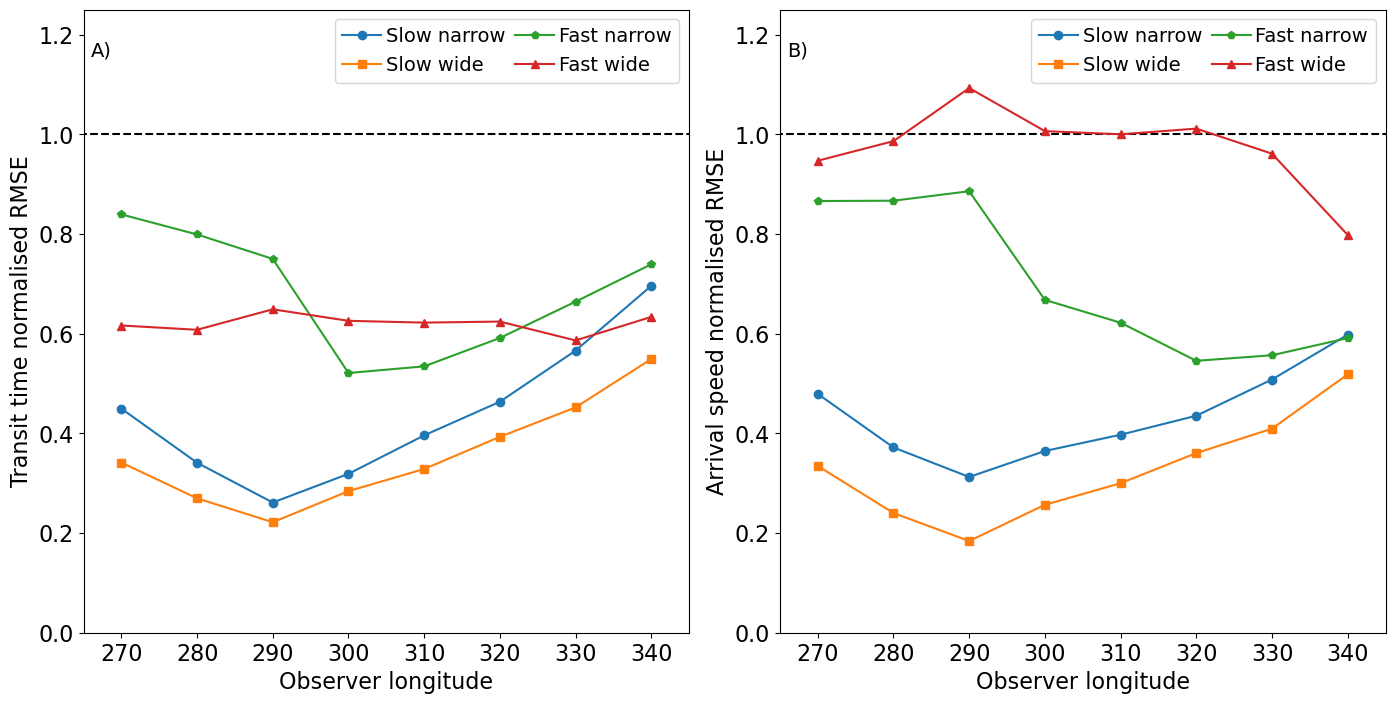

In [7]:
lons = np.array([270, 280, 290, 300, 310, 320, 330, 340])
stats = ['me', 'std', 'rmse', 'mae']
scenario_style = {'slow_narrow':{'col':'tab:blue','mrk':'o'},
                  'slow_wide':{'col':'tab:orange','mrk':'s'},
                  'fast_narrow':{'col':'tab:green','mrk':'p'},
                  'fast_wide':{'col':'tab:red','mrk':'^'},}

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

for scenario, style in scenario_style.items():
    t_stats = {k:{s:np.zeros(lons.size) for s in stats} for k in ['prior', 'post']}
    v_stats = {k:{s:np.zeros(lons.size) for s in stats} for k in ['prior', 'post']}

    for i, lon in enumerate(lons):
        
        dirs = sir.get_project_dirs()
        dir_tag = 'obs_lon_{}_cme_{}_mp'.format(lon, scenario)
        data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
        files = glob.glob(data_dir)

        data = summarise_osse_data(files)

        t_pri = data['prior']['t_transit']/3600
        t_pos = data['post']['t_transit']/3600
        t_truth = data['truth']['t_transit']/3600

        dt_pri = t_pri - t_truth
        dt_pos = t_pos - t_truth

        t_stats['prior']['me'][i] = np.mean(dt_pri)
        t_stats['post']['me'][i] = np.mean(dt_pos)

        t_stats['prior']['std'][i] = np.std(dt_pri)
        t_stats['post']['std'][i] = np.std(dt_pos)

        t_stats['prior']['mae'][i] = np.mean(np.abs(dt_pri))
        t_stats['post']['mae'][i] = np.mean(np.abs(dt_pos))

        t_stats['prior']['rmse'][i] = np.sqrt(np.mean(dt_pri**2))
        t_stats['post']['rmse'][i] = np.sqrt(np.mean(dt_pos**2))

        v_pri = data['prior']['v_hit']
        v_pos = data['post']['v_hit']
        v_truth = data['truth']['v_hit']

        dv_pri = v_pri - v_truth
        dv_pos = v_pos - v_truth

        v_stats['prior']['me'][i] = np.mean(dv_pri)
        v_stats['post']['me'][i] = np.mean(dv_pos)

        v_stats['prior']['std'][i] = np.std(dv_pri)
        v_stats['post']['std'][i] = np.std(dv_pos)

        v_stats['prior']['mae'][i] = np.mean(np.abs(dv_pri))
        v_stats['post']['mae'][i] = np.mean(np.abs(dv_pos))

        v_stats['prior']['rmse'][i] = np.sqrt(np.mean(dv_pri**2))
        v_stats['post']['rmse'][i] = np.sqrt(np.mean(dv_pos**2))
        
    # Compute fractional rmse of post relative to prior

    t_stats['prior']['rmse_norm'] = t_stats['prior']['rmse'] / t_stats['prior']['rmse']
    t_stats['post']['rmse_norm'] = t_stats['post']['rmse'] / t_stats['prior']['rmse']
    
    v_stats['prior']['rmse_norm'] = v_stats['prior']['rmse'] / v_stats['prior']['rmse']
    v_stats['post']['rmse_norm'] = v_stats['post']['rmse'] / v_stats['prior']['rmse']
    
    label = scenario.replace('_', ' ').capitalize()
    
    ax[0].plot(lons, t_stats['post']['rmse_norm'], color=style['col'], marker=style['mrk'], label=label)
    

    ax[1].plot(lons, v_stats['post']['rmse_norm'], color=style['col'], marker=style['mrk'], label=label)
    
ax[0].hlines(t_stats['prior']['rmse_norm'][0], 260, 360, linestyles=['--'], colors=['k'])
ax[1].hlines(v_stats['prior']['rmse_norm'][0], 260, 360, linestyles=['--'], colors=['k'])

for a, lab in zip(ax, ['A)', 'B)']):
    a.set_xlabel('Observer longitude')
    a.set_xlim(265, 345)
    a.set_ylim(0, 1.25)
    a.legend(ncol=2, fontsize=14, columnspacing=0.5, handletextpad=0.25)
    a.text(0.0125, 0.925, lab, fontsize=14, transform=a.transAxes)
    
ax[0].set_ylabel('Transit time normalised RMSE')
ax[1].set_ylabel('Arrival speed normalised RMSE')

fig.subplots_adjust(left=0.06, bottom=0.1, right=0.99, top=0.99, wspace=0.15)
dirs = sir.get_project_dirs()
name = 'fig6_norm_rmse_vs_lon_all_scenarios.png'
out_path = os.path.join(dirs['figures'], name)
fig.savefig(out_path, facecolor='w')
